In [ ]:
#Basic GAN to generate images of numbers

In [ ]:
import torch  # PyTorch, a popular open-source deep learning library for building and training neural networks.
import pdb  # Python Debugger, used for debugging and interactive exploration of code.
from torch.utils.data import DataLoader  # PyTorch DataLoader, used for efficiently loading and batching data during training.
from torch import nn  # Neural network module of PyTorch, provides building blocks for creating and training neural networks.
from torchvision import transforms  # torchvision library provides common image transformations and utilities for computer vision tasks.
from torchvision.datasets import MNIST  # MNIST dataset, a collection of 28x28 grayscale images of handwritten digits (0-9).
from torchvision.utils import make_grid  # Utility function for creating a grid of images, often used for visualization.
from tqdm.auto import tqdm  # tqdm, a library for adding progress bars to loops, helpful for tracking the progress of training.
import matplotlib.pyplot as plt  # Matplotlib, a popular plotting library for creating static, interactive, and animated visualizations.


In [ ]:
#create a function to create a grid of the real images of the numbers
#vs the fake ones
def show(tensor, ch=1, size=(28,28), num=16):
  #the dimensions of tensor as 128(processes 128 pics at once) x 784(28x28)
  #preparing the tensor for visualization or further processing. It detaches it from the computation graph, moves it to the CPU, and reshapes it to have a specific format suitable for working with image data in PyTorch
  data=tensor.detach().cpu().view(-1,ch,*size) #128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) #1x28x28=28x28x1 change the order of dimensions because of matplotlib
  plt.imshow(grid)
  plt.show()

In [ ]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

# number of steps = 60000 / 128 = 468.75

100%|██████████| 9912422/9912422 [00:00<00:00, 21965259.42it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 116476628.68it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31076372.85it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20374897.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# # Setting the number of training epochs
# epoch = 500
# # Initializing the current step in the training process
# cur_step = 0
# # Specifying the frequency at which to print information during training
# info_step = 300
# # Initializing mean generator and discriminator loss variables
# mean_gen_loss = 0
# mean_disc_loss = 0
# # Setting the dimensionality of the random noise vector used as input to the generator
# z_dim = 64
# # Setting the learning rate for the optimizer
# lr = 0.00001
# # Defining the loss function for the GAN (Generative Adversarial Network)
# loss_fnc = nn.BCEWithLogitsLoss()
# # Setting the batch size for the DataLoader
# bs = 128
# # Specifying the device for training in parallel
# device = 'cuda'
# # Creating a DataLoader for the MNIST dataset
# dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()))
# # MNIST dataset is loaded from the current directory ('.') with image transformations to tensor format and it has 6



In [ ]:
# declare our models

# Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

**Choice of Activation Function**
The main difference between Leaky ReLU and ReLU is in how they handle negative input values. In ReLU, any negative input is mapped to zero, while Leaky ReLU allows a small, positive gradient for negative input values, preventing them from being completely ignored.

The use of Leaky ReLU in the discriminator is a common practice in building Generative Adversarial Networks (GANs). Leaky ReLU helps to address the issue of "dying neurons," where neurons can become unresponsive during training because they always output zero. This is particularly relevant in the discriminator, where you want the model to be able to provide meaningful gradients even for inputs that might be considered fake. The small negative slope in Leaky ReLU allows the flow of a small gradient for negative values, preventing neurons from becoming completely inactive.


In [ ]:
#Building our Model
## Discriminator
#It tells whether the image generated is real or fake,it takes the input from the generator class and predicts output as 1(real) or 0(fake)
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)

In [ ]:
#creating an instance of the class of the generator and discriminator
#using adam optimizer,adjusts the weights in the back propagation,calculates the gradients ,applying the correct learning rate and updating the parameters
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([2, 7, 0, 5, 9, 9, 8, 7, 7, 6])


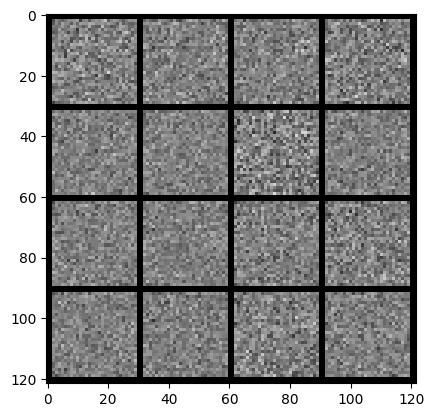

In [ ]:
x,y=next(iter(dataloader))#it loads the data in batches from the large dataset
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)
#this is pure random probabilistic noise and transform it to images of numbers

In [ ]:
# Generator loss calculation
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   # Generate random noise for the generator
   noise = gen_noise(number, z_dim)
   # Generate fake data using the generator
   fake = gen(noise)
   # Pass the generated fake data through the discriminator
   pred = disc(fake)
   # Create target labels (ones) for the generated data,as we want it to predict images as real,so 1
   targets = torch.ones_like(pred)
   # Calculate the generator loss using the specified loss function
   gen_loss = loss_func(pred, targets)

   return gen_loss


# Discriminator loss calculation
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   # Generate random noise for the generator
   noise = gen_noise(number, z_dim)
   # Generate fake data using the generator
   fake = gen(noise)
   # Pass the generated fake data through the discriminator (detach to avoid backpropagating through the generator)
   disc_fake = disc(fake.detach())
   # Create target labels (zeros) for the generated data
   disc_fake_targets = torch.zeros_like(disc_fake)
   # Calculate the discriminator loss for the generated data
   disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

   # Pass real data through the discriminator
   disc_real = disc(real)
   # Create target labels (ones) for the real data
   disc_real_targets = torch.ones_like(disc_real)
   # Calculate the discriminator loss for the real data
   disc_real_loss = loss_func(disc_real, disc_real_targets)

   # Combine the losses for real and fake data to get the total discriminator loss
   disc_loss = (disc_fake_loss + disc_real_loss) / 2

   return disc_loss


  0%|          | 0/469 [00:00<?, ?it/s]

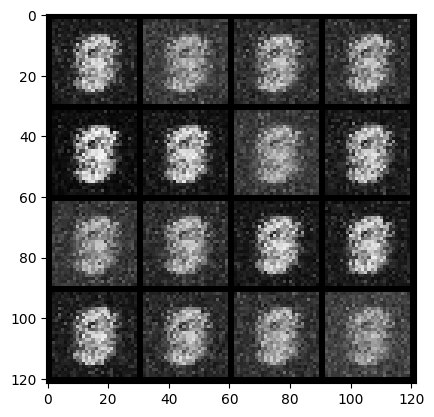

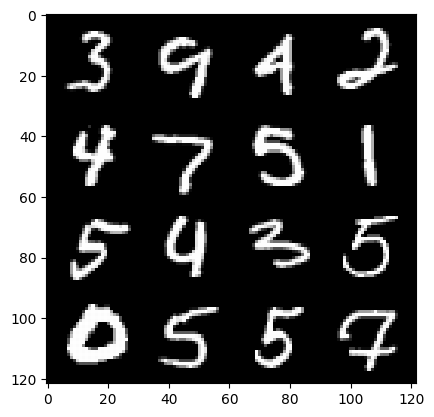

0: step 300 / Gen loss: 1.9481038171052938 / disc_loss: 0.3350875192880628


  0%|          | 0/469 [00:00<?, ?it/s]

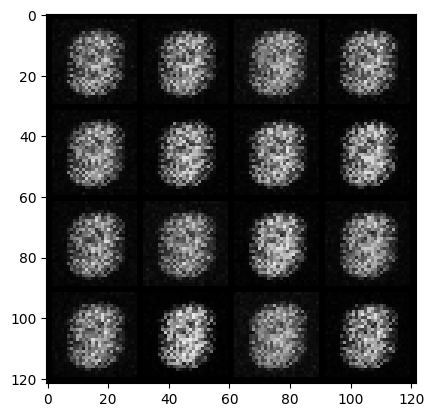

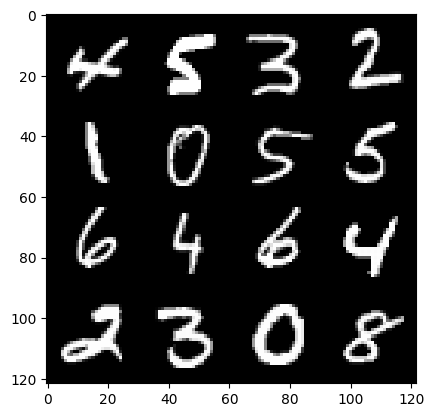

1: step 600 / Gen loss: 3.5463874244689992 / disc_loss: 0.11704265691339971


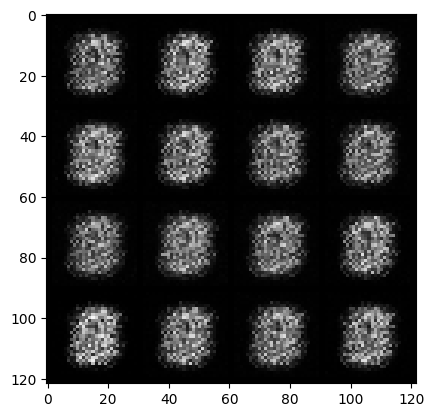

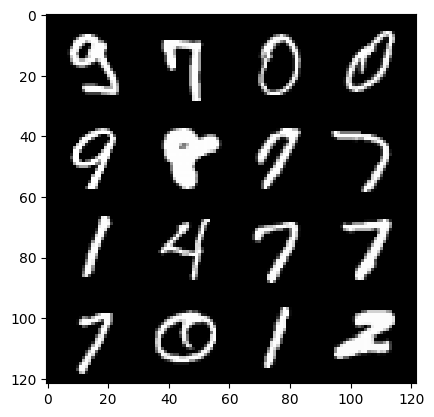

1: step 900 / Gen loss: 3.5348545400301616 / disc_loss: 0.051377301389972346


  0%|          | 0/469 [00:00<?, ?it/s]

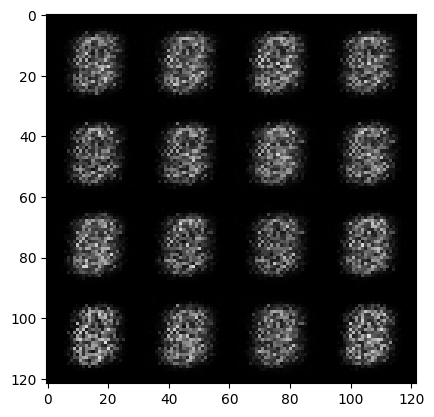

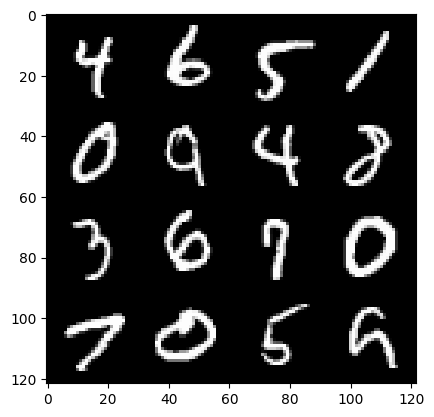

2: step 1200 / Gen loss: 3.5969383080800386 / disc_loss: 0.03473572241763275


  0%|          | 0/469 [00:00<?, ?it/s]

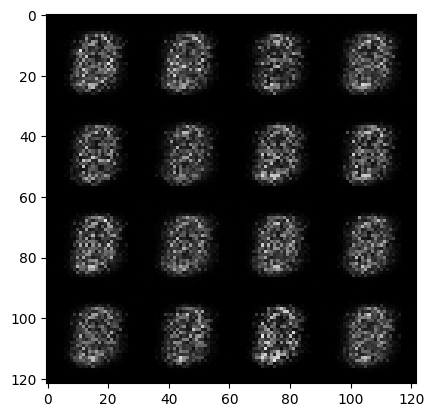

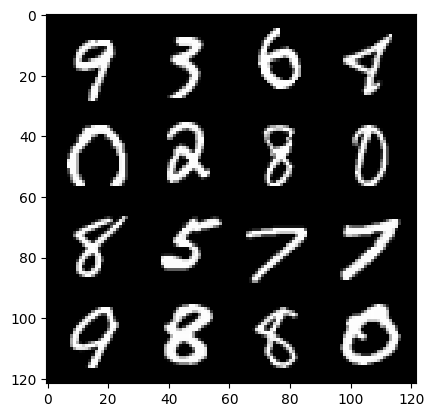

3: step 1500 / Gen loss: 3.577373712062835 / disc_loss: 0.034636774975806486


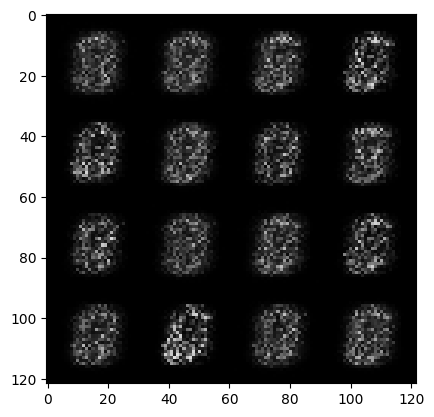

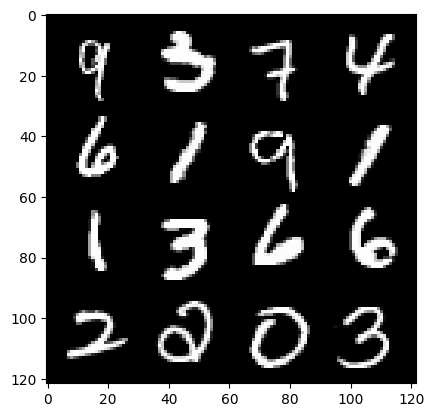

3: step 1800 / Gen loss: 3.5124000636736565 / disc_loss: 0.04052339065199096


  0%|          | 0/469 [00:00<?, ?it/s]

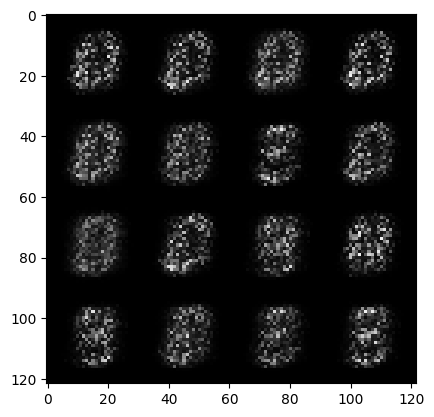

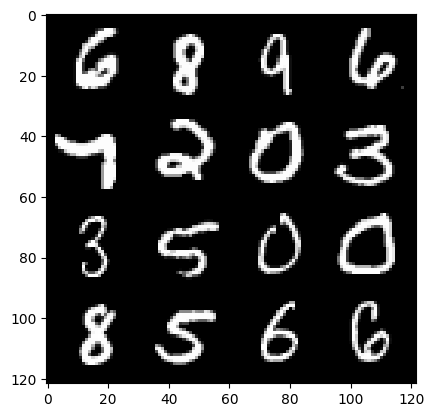

4: step 2100 / Gen loss: 3.747635667324065 / disc_loss: 0.04101556689788898


  0%|          | 0/469 [00:00<?, ?it/s]

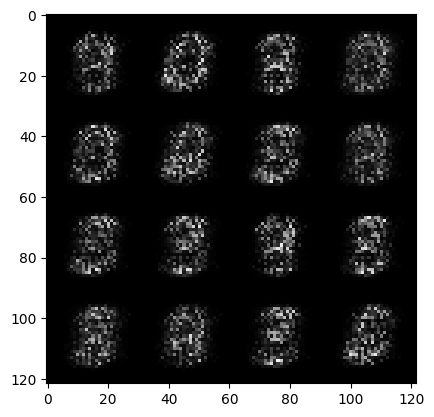

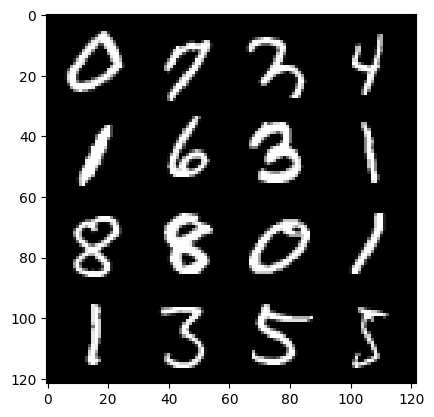

5: step 2400 / Gen loss: 3.907365005811058 / disc_loss: 0.03440862326572338


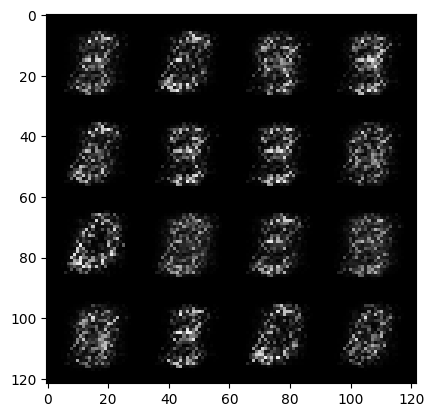

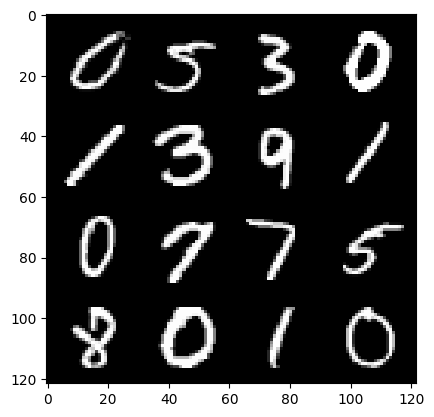

5: step 2700 / Gen loss: 4.6434168028831495 / disc_loss: 0.02339732359163465


  0%|          | 0/469 [00:00<?, ?it/s]

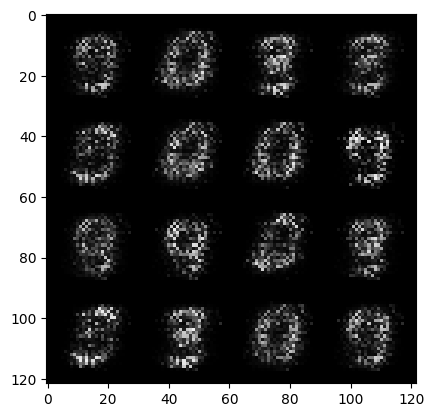

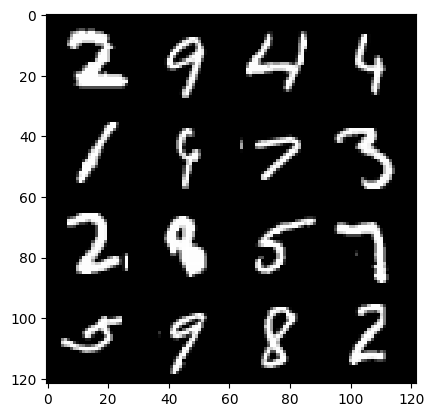

6: step 3000 / Gen loss: 5.145062117576598 / disc_loss: 0.021443950496613965


  0%|          | 0/469 [00:00<?, ?it/s]

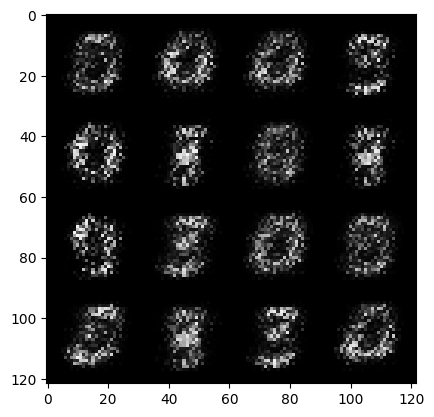

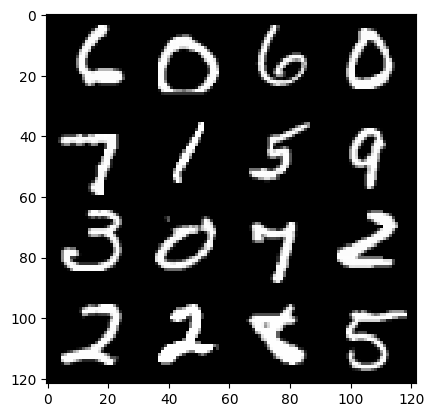

7: step 3300 / Gen loss: 5.179547764460248 / disc_loss: 0.01961281446429591


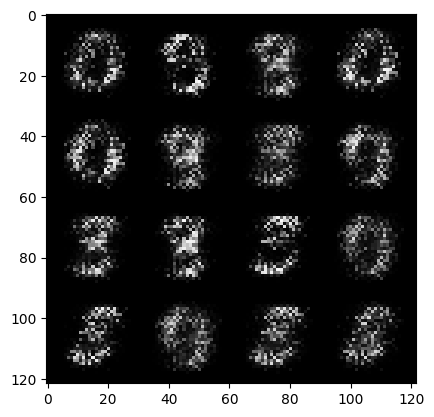

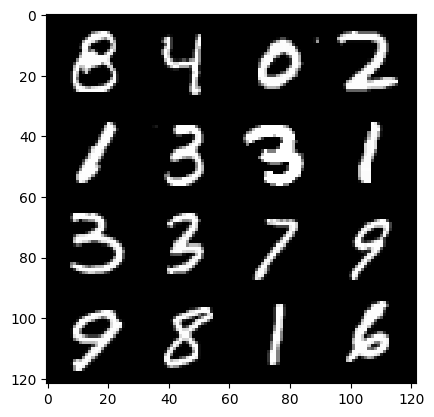

7: step 3600 / Gen loss: 5.239683621724447 / disc_loss: 0.020703120312343053


  0%|          | 0/469 [00:00<?, ?it/s]

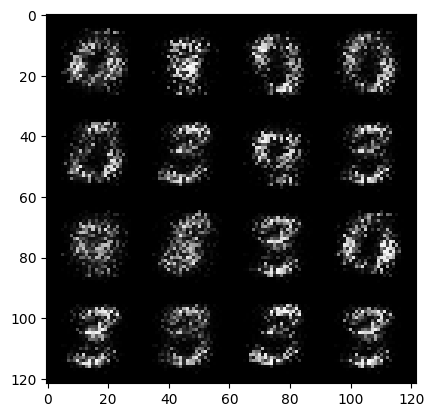

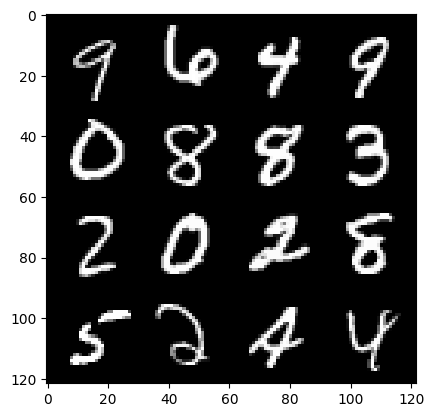

8: step 3900 / Gen loss: 5.396143646240235 / disc_loss: 0.019149498008191577


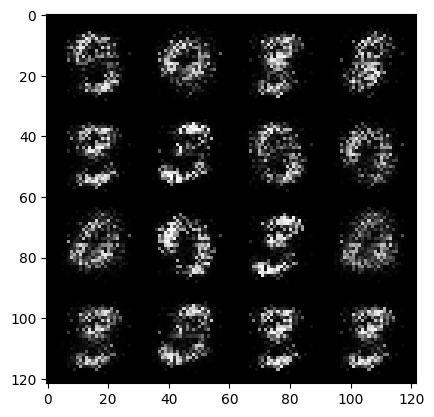

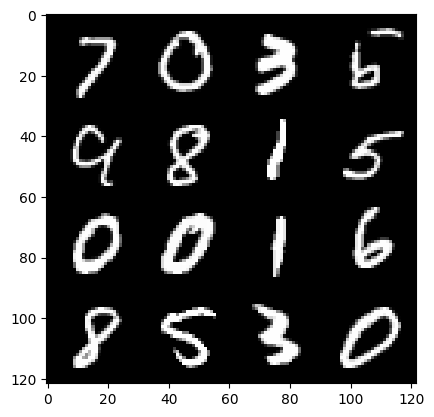

8: step 4200 / Gen loss: 5.8144536526997905 / disc_loss: 0.016802535260406638


  0%|          | 0/469 [00:00<?, ?it/s]

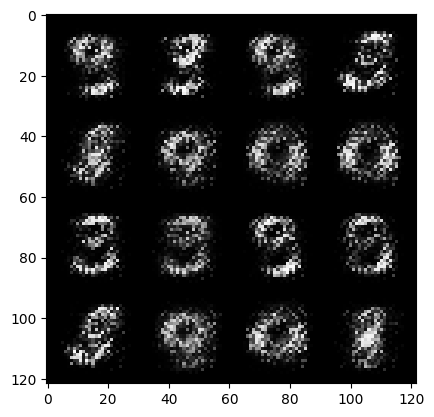

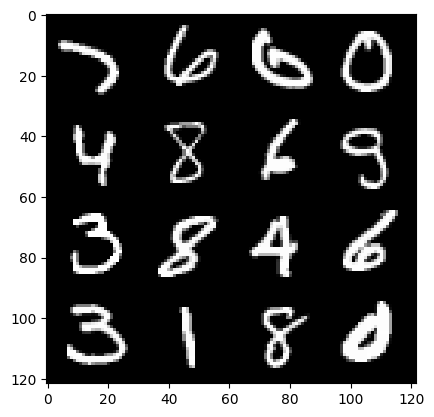

9: step 4500 / Gen loss: 6.196769920984897 / disc_loss: 0.014840496239873265


  0%|          | 0/469 [00:00<?, ?it/s]

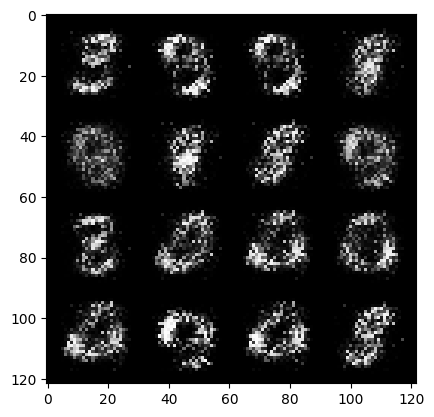

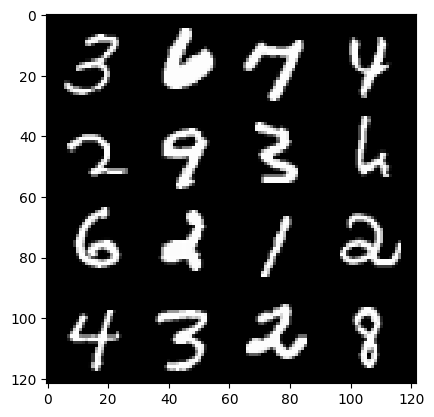

10: step 4800 / Gen loss: 6.508050923347474 / disc_loss: 0.013418629864851627


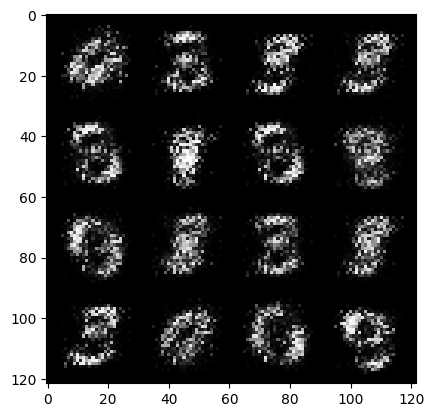

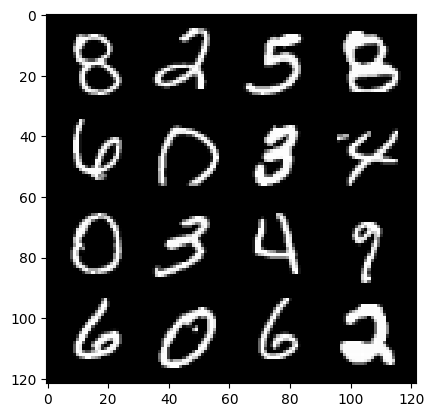

10: step 5100 / Gen loss: 6.2698337348302235 / disc_loss: 0.011841268718708307


  0%|          | 0/469 [00:00<?, ?it/s]

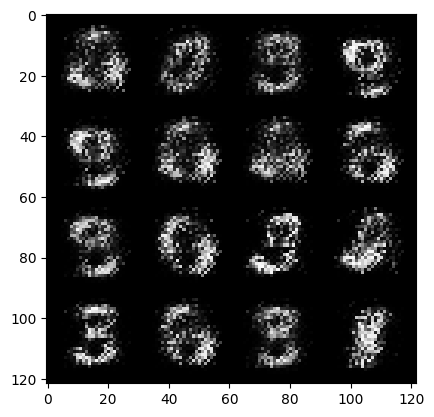

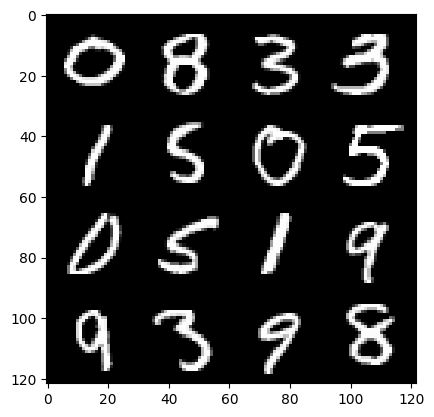

11: step 5400 / Gen loss: 6.240733693440754 / disc_loss: 0.013813365157693625


  0%|          | 0/469 [00:00<?, ?it/s]

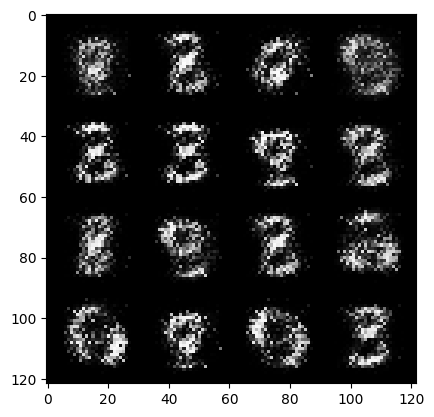

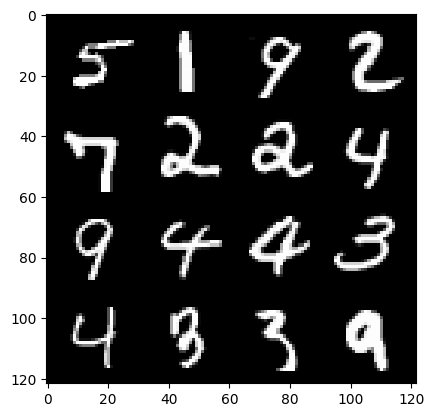

12: step 5700 / Gen loss: 6.546771451632184 / disc_loss: 0.01047420143537845


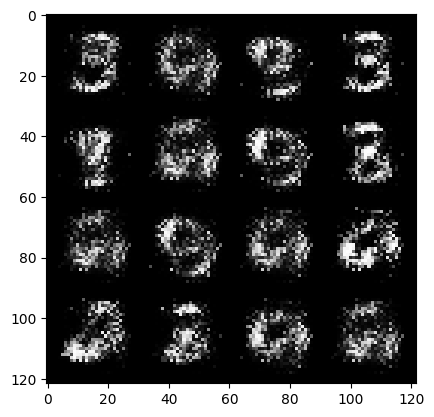

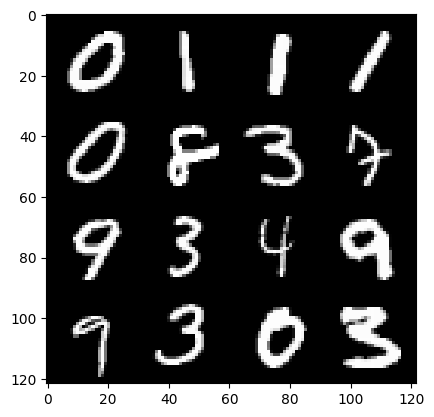

12: step 6000 / Gen loss: 6.869411233266195 / disc_loss: 0.010772407605933653


  0%|          | 0/469 [00:00<?, ?it/s]

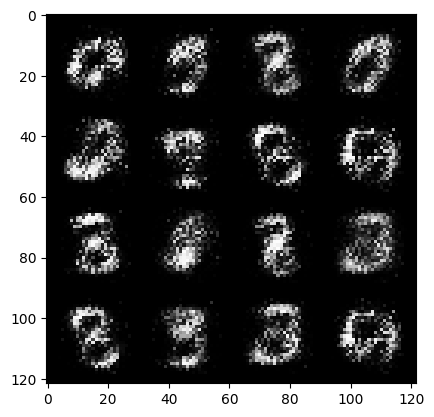

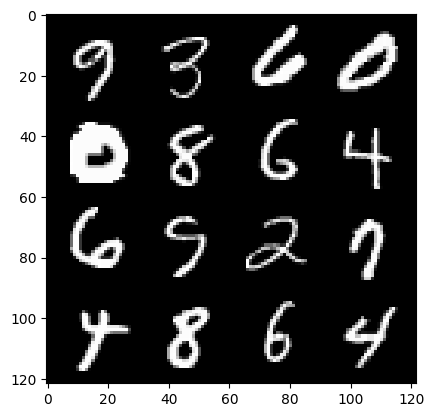

13: step 6300 / Gen loss: 6.655494240125021 / disc_loss: 0.012254087253628919


  0%|          | 0/469 [00:00<?, ?it/s]

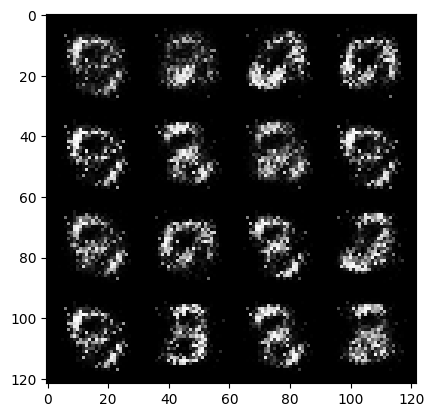

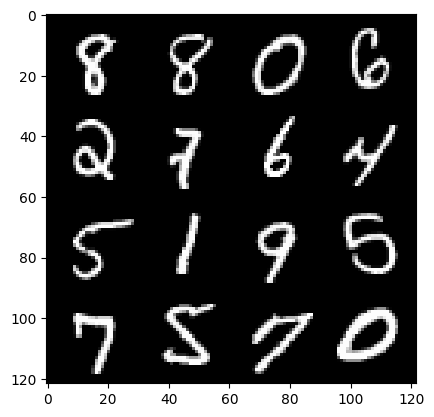

14: step 6600 / Gen loss: 6.763997465769454 / disc_loss: 0.01093892016448081


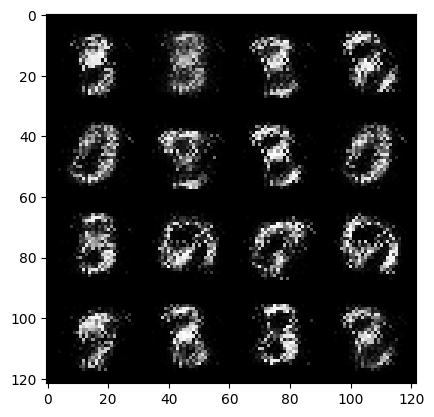

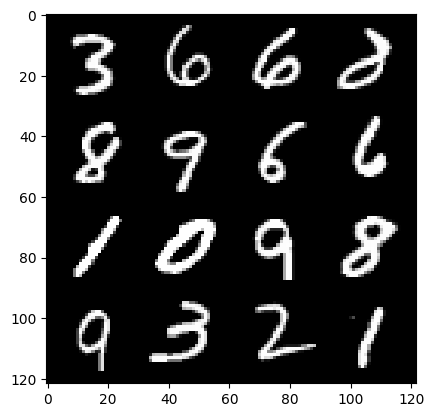

14: step 6900 / Gen loss: 6.906224799156187 / disc_loss: 0.011933486224928255


  0%|          | 0/469 [00:00<?, ?it/s]

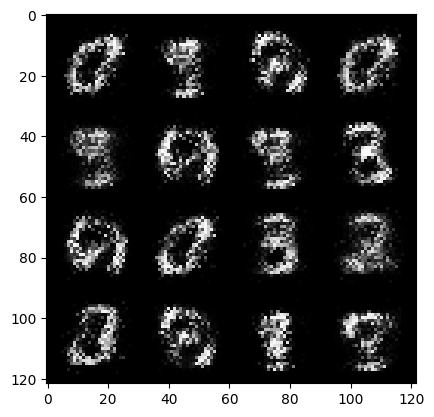

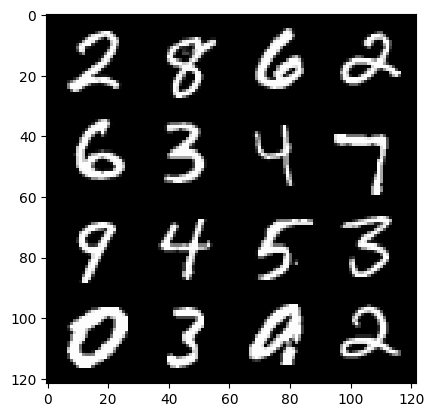

15: step 7200 / Gen loss: 6.717254956563313 / disc_loss: 0.013153570299812893


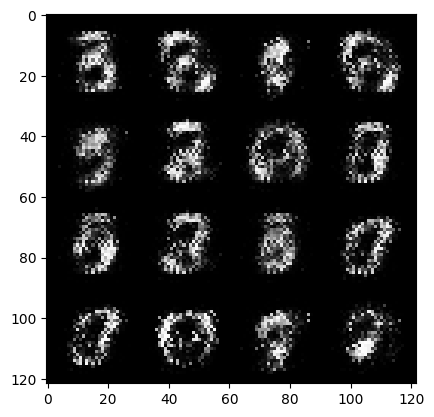

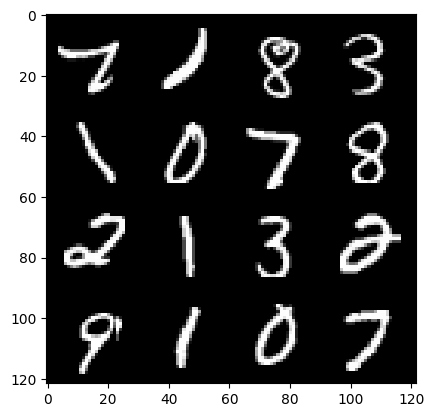

15: step 7500 / Gen loss: 6.862037356694538 / disc_loss: 0.012958200467595205


  0%|          | 0/469 [00:00<?, ?it/s]

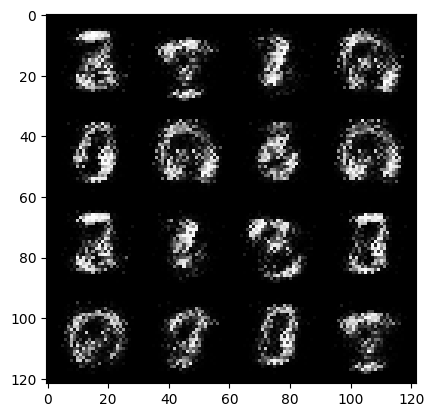

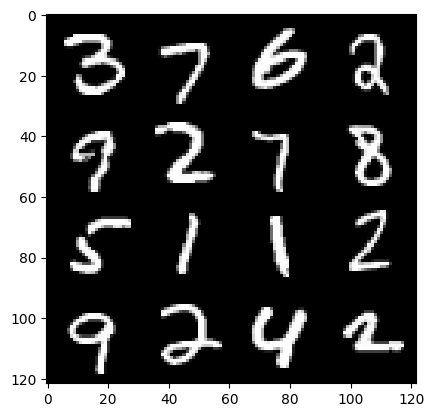

16: step 7800 / Gen loss: 7.146023761431376 / disc_loss: 0.012896217175293708


  0%|          | 0/469 [00:00<?, ?it/s]

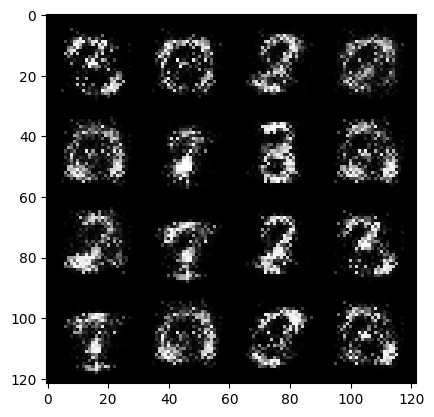

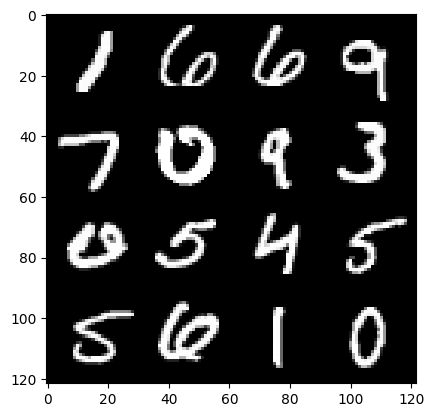

17: step 8100 / Gen loss: 7.001601495742797 / disc_loss: 0.012647741562686854


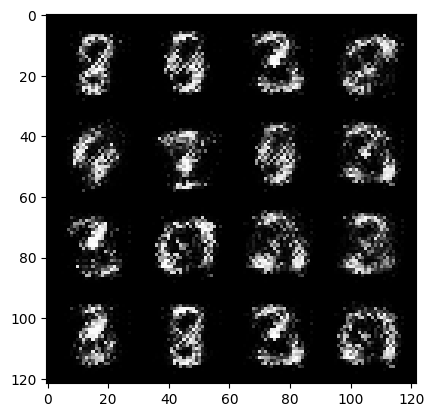

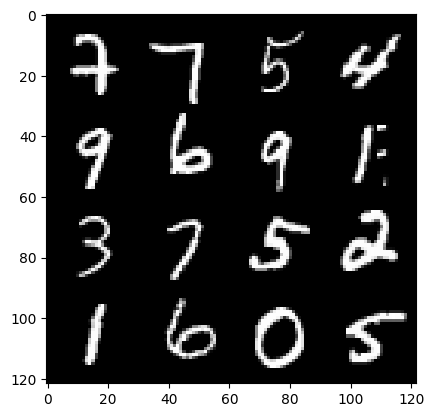

17: step 8400 / Gen loss: 6.859622530937202 / disc_loss: 0.011702215954040487


  0%|          | 0/469 [00:00<?, ?it/s]

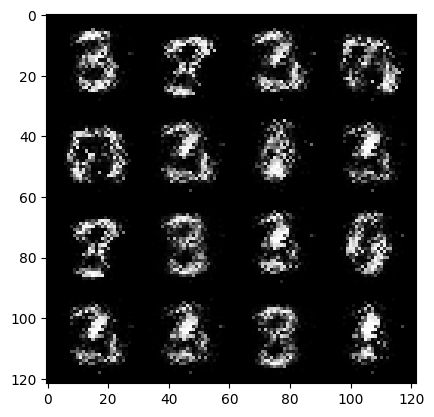

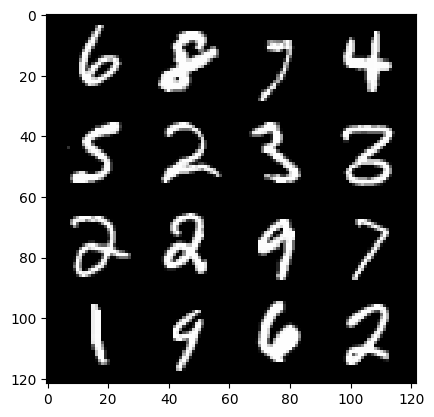

18: step 8700 / Gen loss: 6.668991327285767 / disc_loss: 0.010104345013387497


  0%|          | 0/469 [00:00<?, ?it/s]

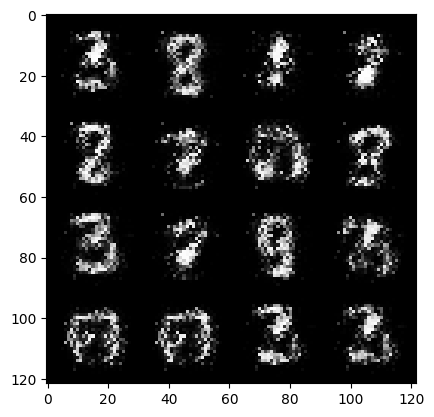

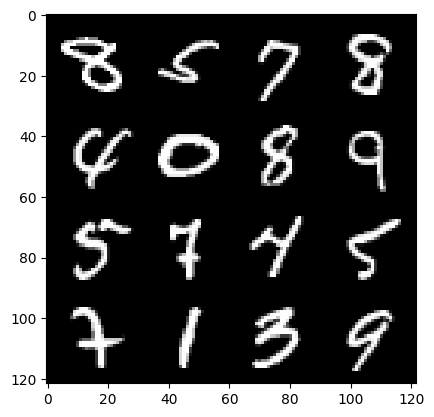

19: step 9000 / Gen loss: 6.972610090573625 / disc_loss: 0.008579360773631677


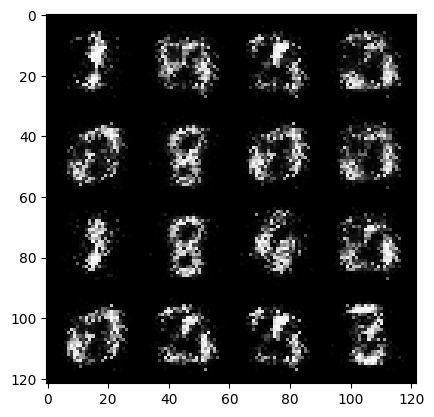

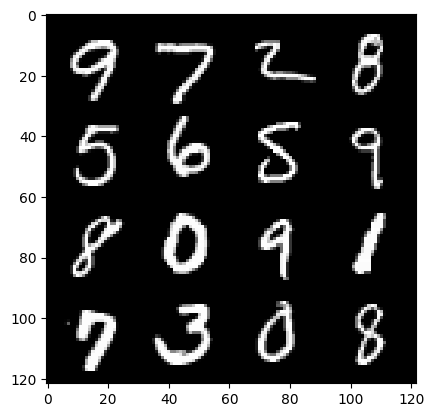

19: step 9300 / Gen loss: 7.4877004098892215 / disc_loss: 0.009878940668034675


In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1
